# Imports and Google Colab stuff.

In [1]:
# change this to your working directory!
directory = '/content/gdrive/MyDrive/Colab Notebooks/cs89.21'
# change this to your CUDA path
cuda_home = '/usr/local/cuda-10.1/'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd $directory
!pip install sparse
!pip install hatespans
!pip install torch==1.7.1
!pip install -r '$directory/requirements.txt'
!pip install pytorch-pretrained-bert==0.4.0
!pip install scipy --upgrade
!pip install scikit-multilearn
!pip freeze > ./requirements.txt

/content/gdrive/MyDrive/Colab Notebooks/cs89.21
     |████████████████████████████████| 81kB 7.3MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 317kB 20.5MB/s 
     |████████████████████████████████| 10.4MB 33.2MB/s 
     |████████████████████████████████| 1.3MB 55.0MB/s 
     |████████████████████████████████| 9.5MB 45.6MB/s 
     |████████████████████████████████| 1.8MB 50.5MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 1.1MB 48.8MB/s 
     |████████████████████████████████| 890kB 46.5MB/s 
     |████████████████████████████████| 2.9MB 50.0MB/s 
     |████████████████████████████████| 1.1MB 52.5MB/s 
     |████████████████████████████████| 163kB 68.0MB/s 
     |████████████████████████████████| 133kB 66.0MB/s 
     |████████████████████████████████| 102kB 11.9MB/s 
     |████████████████████████████████| 81kB 10.7MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
  Create

     |████████████████████████████████| 776.8MB 21kB/s 
ERROR: torchvision 0.9.0+cu101 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
     |████████████████████████████████| 133kB 13.5MB/s 
     |████████████████████████████████| 7.3MB 12.4MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
     |████████████████████████████████| 92kB 12.1MB/s 
     |████████████████████████████████| 27.4MB 1.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: botocore 1.20.28 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
  Found existing installati

In [2]:
%cd $directory
import json
import os
os.environ['CUDA_HOME'] = cuda_home
import torch
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
if not '/content/gdrive/My Drive/Colab Notebooks/cs99/bertviz' in sys.path:
  sys.path += ['/content/gdrive/My Drive/Colab Notebooks/cs99/bertviz']
from bertviz import head_view, model_view
import IPython
from IPython.display import Javascript
from tqdm import tqdm
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
from itertools import product
if '/content/gdrive/MyDrive/Colab Notebooks/cs99/new-mt-dnn' not in sys.path:
  sys.path += ['/content/gdrive/MyDrive/Colab Notebooks/cs99/new-mt-dnn']
from run_bertology import compute_heads_importance, mask_heads, prune_heads
from scipy.stats import pearsonr
import random
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import argparse
from datetime import datetime
from utils import *
from transformers import *
import collections
from tokenizers import BertWordPieceTokenizer
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
from nltk import ngrams
from random import randrange
import math
from torch.nn import BCEWithLogitsLoss, BCELoss
from ast import literal_eval
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import roc_curve, auc
import spacy
from nltk import word_tokenize
import nltk
nltk.download('punkt')
from scipy.stats import ttest_ind

/content/gdrive/MyDrive/Colab Notebooks/cs89.21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if __name__ == '__main__':


Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load, explore, and preprocess data.

In [11]:
jigsaw_train = pd.read_csv('{}/data/train.csv'.format(directory))
jigsaw_test = pd.read_csv('{}/data/test.csv'.format(directory))
jigsaw_test_labels = pd.read_csv('{}/data/test_labels.csv'.format(directory))
jigsaw_test = pd.merge(jigsaw_test, jigsaw_test_labels, how='left', on='id')
jigsaw_test = jigsaw_test[jigsaw_test['toxic'] != -1]
jigsaw_asian = pd.read_csv('{}/data/Anti-Asian_tweets.csv'.format(directory))
jigsaw_asian = jigsaw_asian[~jigsaw_asian['text'].isna()]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,6,7,8,10,15,16,17,22,27,28,29,30,31,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
print('How many samples are in each dataset?')
print('train: {}'.format(jigsaw_train.shape))
print('test: {}'.format(jigsaw_test.shape))

How many samples are in each dataset?
train: (159571, 8)
test: (63978, 8)


In [24]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print('How many positive/negative samples are there for each label?:\n')
for column in labels:
  print(column)
  print(jigsaw_train[column].value_counts())
  print('\n')

How many positive/negative samples are there for each label?:

toxic
0    144277
1    15294 
Name: toxic, dtype: int64


severe_toxic
0    157976
1    1595  
Name: severe_toxic, dtype: int64


obscene
0    151122
1    8449  
Name: obscene, dtype: int64


threat
0    159093
1    478   
Name: threat, dtype: int64


insult
0    151694
1    7877  
Name: insult, dtype: int64


identity_hate
0    158166
1    1405  
Name: identity_hate, dtype: int64




In [8]:
print('What does, say, a toxic sample look like?')
jigsaw_train[jigsaw_train['toxic']==1].sample(1)

What does, say, a toxic sample look like?


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
29736,4eebb8e3c468c6fb,stop being a pussbot \n\nstop being a pussbot. you are extremely biased. Wikipedia cannto tolerate users like you. stop being a shudslavpus,1,0,1,0,1,0


Looks like texts may be littered with '\n' characters. This shouldn't be a problem, however, as our BERT tokenizer (below) will ignore such characters.

# Tokenize the data.
- Note: We also tried model_type=bert-base-uncased with do_lower_case=True. However, we omit the code for training that model as it is totally analogous to the code below.

In [12]:
model_type = 'bert-base-cased'
do_lower_case = False
batch_size = 32
tokenizer = BertTokenizerFast.from_pretrained(model_type, do_lower_case=do_lower_case)

In [ ]:
# If you run out of GPU memory running this cell, try performing the loop below in batches :)
encodings = []
for text in tqdm(jigsaw_train['comment_text']):
  encoding = tokenizer.batch_encode_plus([text], max_length=512, pad_to_max_length=True)
  encodings.append(encoding)

In [ ]:
encodings_combined = {key:[encoding[key][0] for encoding in encodings] for key in encodings[0].keys()}
encodings = encodings_combined
#pkl.dump(encodings, open('{}/train_set_encodings.pkl'.format(directory), 'wb'))

In [ ]:
# Again, if you run out of GPU memory running this cell, try performing the loop below in batches.
encodings = []
for text in tqdm(jigsaw_test['comment_text']):
  encoding = tokenizer.batch_encode_plus([text], max_length=512, pad_to_max_length=True)
  encodings.append(encoding)

In [ ]:
encodings_combined = {key:[encoding[key][0] for encoding in encodings] for key in encodings[0].keys()}
encodings = encodings_combined
#pkl.dump(encodings, open('{}/test_encodings.pkl'.format(directory), 'wb'))

In [13]:
# Again, if you run out of GPU memory running this cell, try performing the loop below in batches.
encodings = []
for text in tqdm(jigsaw_asian['text']):
  encoding = tokenizer.batch_encode_plus([text], max_length=512, pad_to_max_length=True)
  encodings.append(encoding)

  0%|          | 0/28408 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 28408/28408 [00:06<00:00, 4379.77it/s]


In [14]:
encodings_combined = {key:[encoding[key][0] for encoding in encodings] for key in encodings[0].keys()}
encodings = encodings_combined
#pkl.dump(encodings, open('{}/asian_encodings.pkl'.format(directory), 'wb'))

In [15]:
jigsaw_train_encodings = pkl.load(open('{}/train_encodings.pkl'.format(directory), 'rb'))
jigsaw_test_encodings = pkl.load(open('{}/test_encodings.pkl'.format(directory), 'rb'))
jigsaw_asian_encodings = pkl.load(open('{}/anti_asian_tweets_encodings.pkl'.format(directory), 'rb'))

In [17]:
jigsaw_train_input_ids = jigsaw_train_encodings['input_ids']
jigsaw_train_token_type_ids = jigsaw_train_encodings['token_type_ids']
jigsaw_train_attention_masks = jigsaw_train_encodings['attention_mask'] 
jigsaw_test_input_ids = jigsaw_test_encodings['input_ids']
jigsaw_test_token_type_ids = jigsaw_test_encodings['token_type_ids']
jigsaw_test_attention_masks = jigsaw_test_encodings['attention_mask'] 
jigsaw_asian_input_ids = jigsaw_asian_encodings['input_ids']
jigsaw_asian_token_type_ids = jigsaw_asian_encodings['token_type_ids']
jigsaw_asian_attention_masks = jigsaw_asian_encodings['attention_mask'] 

Since we are doing multi-label classification, we should be careful with how we stratify the labels across the samples in our train and dev set.

In [12]:
jigsaw_train_idx = np.arange(jigsaw_train.shape[0]).reshape(-1, 1)
jigsaw_train_y = jigsaw_train[labels].values
#jigsaw_train_mini_idx, jigsaw_train_mini_y, jigsaw_dev_mini_idx, jigsaw_dev_mini_y = iterative_train_test_split(jigsaw_train_idx, jigsaw_train_y, test_size=0.1)
#jigsaw_train_mini = jigsaw_train.iloc[jigsaw_train_mini_idx.ravel()]
#jigsaw_dev_mini = jigsaw_train.iloc[jigsaw_dev_mini_idx.ravel()]
#torch.save(jigsaw_train_mini_idx, '{}/train_mini_idx_for_cased_not_lowered.pt'.format(directory))
jigsaw_train_mini_idx = torch.load('{}/train_mini_idx_for_cased_not_lowered.pt'.format(directory))
jigsaw_dev_mini_idx = np.array(list(set(jigsaw_train.index) - set(jigsaw_train_mini_idx.ravel()))).reshape(-1, 1)
jigsaw_super_mini_idx = torch.load('{}/super_mini_idx_for_cased_not_lowered.pt'.format(directory))
jigsaw_train_mini = jigsaw_train.iloc[jigsaw_train_mini_idx.ravel()]
jigsaw_dev_mini = jigsaw_train.iloc[jigsaw_dev_mini_idx.ravel()]
jigsaw_super_mini = jigsaw_train.iloc[jigsaw_super_mini_idx.ravel()]
jigsaw_train_mini_y = jigsaw_train_mini[labels].values
jigsaw_dev_mini_y = jigsaw_dev_mini[labels].values
jigsaw_super_mini_y = jigsaw_super_mini[labels].values
jigsaw_train_mini['one_hot'] = jigsaw_train_mini[labels].values.tolist()
jigsaw_dev_mini['one_hot'] = jigsaw_dev_mini[labels].values.tolist()
jigsaw_test_y = jigsaw_test[labels].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
jigsaw_train_mini_input_ids = torch.tensor(np.array(jigsaw_train_input_ids)[jigsaw_train_mini_idx.ravel()].tolist())
jigsaw_dev_mini_input_ids = torch.tensor(np.array(jigsaw_train_input_ids)[jigsaw_dev_mini_idx.ravel()].tolist())
jigsaw_super_mini_input_ids = torch.tensor(np.array(jigsaw_train_input_ids)[jigsaw_super_mini_idx.ravel()].tolist())
jigsaw_train_mini_token_type_ids = torch.tensor(np.array(jigsaw_train_token_type_ids)[jigsaw_train_mini_idx.ravel()].tolist())
jigsaw_dev_mini_token_type_ids = torch.tensor(np.array(jigsaw_train_token_type_ids)[jigsaw_dev_mini_idx.ravel()].tolist())
jigsaw_super_mini_token_type_ids = torch.tensor(np.array(jigsaw_train_token_type_ids)[jigsaw_super_mini_idx.ravel()].tolist())
jigsaw_train_mini_attention_masks = torch.tensor(np.array(jigsaw_train_attention_masks)[jigsaw_train_mini_idx.ravel()].tolist())
jigsaw_dev_mini_attention_masks = torch.tensor(np.array(jigsaw_train_attention_masks)[jigsaw_dev_mini_idx.ravel()].tolist())
jigsaw_super_mini_attention_masks = torch.tensor(np.array(jigsaw_train_attention_masks)[jigsaw_super_mini_idx.ravel()].tolist())
jigsaw_train_mini_y = torch.tensor(jigsaw_train_mini_y)
jigsaw_dev_mini_y = torch.tensor(jigsaw_dev_mini_y)
jigsaw_super_mini_y = torch.tensor(jigsaw_super_mini_y)
jigsaw_test_input_ids = torch.tensor(jigsaw_test_input_ids)
jigsaw_test_token_type_ids = torch.tensor(jigsaw_test_token_type_ids)
jigsaw_test_attention_masks = torch.tensor(jigsaw_test_attention_masks)
jigsaw_test_y = torch.tensor(jigsaw_test_y)
jigsaw_asian_input_ids = torch.tensor(jigsaw_asian_input_ids)
jigsaw_asian_token_type_ids = torch.tensor(jigsaw_asian_token_type_ids)
jigsaw_asian_attention_masks = torch.tensor(jigsaw_asian_attention_masks)

In [14]:
jigsaw_train_mini_data = TensorDataset(jigsaw_train_mini_input_ids, jigsaw_train_mini_token_type_ids, jigsaw_train_mini_attention_masks, jigsaw_train_mini_y)
jigsaw_train_sampler = RandomSampler(jigsaw_train_mini_data)
jigsaw_train_dataloader = DataLoader(jigsaw_train_mini_data, sampler=jigsaw_train_sampler, batch_size=batch_size)
jigsaw_dev_mini_data = TensorDataset(jigsaw_dev_mini_input_ids, jigsaw_dev_mini_token_type_ids, jigsaw_dev_mini_attention_masks, jigsaw_dev_mini_y)
jigsaw_dev_mini_sampler = RandomSampler(jigsaw_dev_mini_data)
jigsaw_dev_mini_dataloader = DataLoader(jigsaw_dev_mini_data, sampler=jigsaw_dev_mini_sampler, batch_size=batch_size)
jigsaw_super_mini_data = TensorDataset(jigsaw_super_mini_input_ids, jigsaw_super_mini_token_type_ids, jigsaw_super_mini_attention_masks, jigsaw_super_mini_y)
jigsaw_super_mini_sampler = RandomSampler(jigsaw_super_mini_data)
jigsaw_super_mini_dataloader = DataLoader(jigsaw_super_mini_data, sampler=jigsaw_super_mini_sampler, batch_size=batch_size)
jigsaw_test_data = TensorDataset(jigsaw_test_input_ids, jigsaw_test_token_type_ids, jigsaw_test_attention_masks, jigsaw_test_y)
jigsaw_test_dataloader = DataLoader(jigsaw_test_data, batch_size=batch_size)
jigsaw_asian_data = TensorDataset(jigsaw_asian_input_ids, jigsaw_asian_token_type_ids, jigsaw_asian_attention_masks)
jigsaw_asian_dataloader = DataLoader(jigsaw_asian_data, batch_size=batch_size)

# Load model.
- Note: We may need to grid search optimizer parameters in the future.
- Note: We set Adam optimizer parameters to values suggested by:
  - https://towardsdatascience.com/transformers-for-multilabel-classification-71a1a0daf5e1

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained(model_type, num_labels=len(labels), output_attentions=True)
if torch.cuda.is_available():
  model.cuda()
model.load_state_dict(torch.load('{}/checkpoints/bert_model_cased_not_lowered/model_1.pt'.format(directory), map_location=device))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

<All keys matched successfully>

In [26]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, correct_bias=True)

# Train model.
- Note: We tried finetuning for 5 epochs behind the scenes, finding that the model overfits beyond 1 epoch. So here, we only finetune for 1 epoch.

In [27]:
checkpoint = 'bert_model_cased_not_lowered'
if not os.path.isdir('{}/checkpoints/{}'.format(directory, checkpoint)):
  os.mkdir('{}/checkpoints/{}'.format(directory, checkpoint))

In [ ]:
epochs = 1
threshold = 0.5
for epoch in tqdm(range(epochs)):
  print('epoch: {}'.format(epoch))
  model.train()
  loss_total = 0
  samples, steps = 0, 0
  for step, batch in enumerate(jigsaw_train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    input_ids, token_type_ids, attention_masks, y = batch
    optimizer.zero_grad()
    outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
    logits = outputs[0]
    loss_function = BCEWithLogitsLoss() 
    loss = loss_function(logits.view(-1, len(labels)), y.type_as(logits).view(-1, len(labels)))
    loss.backward()
    optimizer.step()
    loss_total += loss.item()
    samples += input_ids.shape[0]
    steps += 1
  torch.save(model.state_dict(), '{}/checkpoints/{}/model_{}.pt'.format(directory, checkpoint, epoch+1))
  print('Loss: {}'.format(loss_total/steps))
  model.eval()
  logits_lst, input_ids_lst, y_pred_lst, y_lst = [], [], [], []
  for batch in jigsaw_dev_mini_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, token_type_ids, attention_masks, y = batch
    with torch.no_grad():
      outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
      logits = outputs[0]
      attention = outputs[-1]
      y_pred = torch.sigmoid(logits)
      logits = logits.detach().cpu().numpy()
      y_pred = y_pred.to('cpu').numpy()
      y = y.to('cpu').numpy()
    input_ids_lst.append(input_ids)
    logits_lst.append(logits)
    y_pred_lst.append(y_pred)
    y_lst.append(y)
  y_pred = np.vstack(y_pred_lst)
  y = np.vstack(y_lst)
  y_pred_bool = (y_pred > threshold).astype(int)
  f1 = f1_score(y, y_pred_bool, average='micro')
  accuracy = accuracy_score(y, y_pred_for_threshold)
  print('F1: {}'.format(f1))
  print('Accuracy: {}'.format(accuracy)), y_pred_for_threshold)
  print('F1: {}'.format(f1))
  print('Accuracy: {}'.format(accuracy))


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 0
Loss: 0.04799834548297013



100%|██████████| 1/1 [1:15:35<00:00, 4535.80s/it]

F1: 0.772449602932193
Accuracy: 0.9270585286376739


# Evaluate model.

## Test set

In [ ]:
model.eval()
logits_lst, input_ids_lst, y_pred_lst, y_lst = [], [], [], []
for batch in tqdm(jigsaw_test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  input_ids, token_type_ids, attention_masks, y = batch
  with torch.no_grad():
    outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
    logits = outputs[0]
    attention = outputs[-1]
    y_pred = torch.sigmoid(logits)
    logits = logits.detach().cpu().numpy()
    y_pred = y_pred.to('cpu').numpy()
    y = y.to('cpu').numpy()
  input_ids_lst.append(input_ids)
  logits_lst.append(logits)
  y_pred_lst.append(y_pred)
  y_lst.append(y)
y_pred = np.vstack(y_pred_lst)
y = np.vstack(y_lst)
#np.save('{}/checkpoints/{}/y_pred.npy'.format(directory, checkpoint), y_pred)

100%|██████████| 2000/2000 [10:25<00:00,  3.20it/s]


In [18]:
y_pred = np.load('{}/checkpoints/{}/y_pred.npy'.format(directory, checkpoint))
y = np.vstack([y_lst.to('cpu').numpy() for _, __, ___, y_lst in jigsaw_test_dataloader])

In [19]:
threshold = 0.5
y_pred_bool = (y_pred > threshold).astype(int)
f1 = f1_score(y, y_pred_bool, average='micro')
accuracy = accuracy_score(y, y_pred_bool)
auc_by_label = pd.DataFrame(index=labels, columns=['AUC'])
for i, label in enumerate(labels):
  y_pred_label = y_pred[:,i]
  y_label = y[:,i]
  fpr, tpr, _ = roc_curve(y_label, y_pred_label)
  auc_by_label.loc[label, 'AUC'] = auc(fpr, tpr)
print(classification_report(y, y_pred_bool, target_names=labels, zero_division=0))
print('Mean column-wise F1: {}'.format(f1))
print('Mean column-wise Accuracy: {}'.format(accuracy))
print('Mean column-wise ROC-AUC: {}\n'.format(auc_by_label['AUC'].mean()))
print(auc_by_label)

               precision    recall  f1-score   support

        toxic       0.60      0.85      0.71      6090
 severe_toxic       0.44      0.07      0.12       367
      obscene       0.70      0.74      0.72      3691
       threat       0.80      0.15      0.25       211
       insult       0.66      0.74      0.69      3427
identity_hate       0.76      0.31      0.44       712

    micro avg       0.64      0.74      0.69     14498
    macro avg       0.66      0.48      0.49     14498
 weighted avg       0.65      0.74      0.67     14498
  samples avg       0.07      0.07      0.07     14498

Mean column-wise F1: 0.686833082321274
Mean column-wise Accuracy: 0.8899152833786614
Mean column-wise ROC-AUC: 0.9831997490634947

                    AUC
toxic          0.972827
severe_toxic   0.98854 
obscene        0.981548
threat         0.992519
insult         0.979136
identity_hate  0.984628


## Anti-Asian_tweets set

In [28]:
model.eval()
logits_lst, input_ids_lst, y_pred_lst, y_lst = [], [], [], []
for batch in tqdm(jigsaw_asian_dataloader):
  batch = tuple(t.to(device) for t in batch)
  input_ids, token_type_ids, attention_masks = batch
  with torch.no_grad():
    outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
    logits = outputs[0]
    attention = outputs[-1]
    y_pred = torch.sigmoid(logits)
    logits = logits.detach().cpu().numpy()
    y_pred = y_pred.to('cpu').numpy()
  input_ids_lst.append(input_ids)
  logits_lst.append(logits)
  y_pred_lst.append(y_pred)
y_pred = np.vstack(y_pred_lst)
#np.save('{}/checkpoints/{}/asian_y_pred.npy'.format(directory, checkpoint), y_pred)

100%|██████████| 888/888 [04:34<00:00,  3.23it/s]


In [58]:
results = pd.DataFrame((y_pred>0.5).astype(int))
results.columns = labels
results.insert(0, 'text', jigsaw_asian['text'])
results.to_csv('{}/checkpoints/{}/asian_y_pred.csv'.format(directory, checkpoint))

# Playground

## Super mini dev set
- Why not use the _full_ dev set? Due to memory limitations, unfortunately.

In [23]:
jigsaw_super_mini['comment_text_cleaned'] = jigsaw_super_mini['comment_text'].str.replace('\n', ' ').replace('\t', ' ')
tokens_lst = [(jigsaw_super_mini_input_ids[i] == 102).nonzero(as_tuple=True)[0].item()-1 for i in range(jigsaw_super_mini.shape[0])]
jigsaw_super_mini['idx'] = range(jigsaw_super_mini.shape[0])
tokens_lst = []
for i in range(jigsaw_super_mini.shape[0]):
  row = jigsaw_super_mini_input_ids[i]
  idx = (row == 102).nonzero().item()
  tokens_lst.append(tokenizer.convert_ids_to_tokens(row[:idx+1]))
data = jigsaw_super_mini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following 

In [39]:
!curl -o '$directory/bad-words.txt' https://www.cs.cmu.edu/~biglou/resources/bad-words.txt
bad_words = set()
with open('{}/bad-words.txt'.format(directory), 'r') as file:
  for line in file:
    bad_word = line.strip()
    if len(bad_word) >= 1:
      bad_words.add(bad_word)
bad_words_extended = set()
for bad_word in bad_words:
  bad_words_extended.add(bad_word)
  bad_words_extended.add(bad_word.capitalize())
  bad_words_extended.add(bad_word.upper())
bad_word_spans_lst = []
for comment_text in jigsaw_super_mini['comment_text_cleaned']:
  tokens = word_tokenize(comment_text)
  bad_word_spans = []
  for token in tokens:
    if token in bad_words_extended:
      i = comment_text.find(token)
      bad_word_spans.append((i, i+len(token)))
  bad_word_spans_lst.append(bad_word_spans)
jigsaw_super_mini['bad_word_spans'] = bad_word_spans_lst
bad_word_row_idx = jigsaw_super_mini[jigsaw_super_mini['bad_word_spans'].apply(lambda x: len(x) != 0)]['idx'].to_numpy()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11169  100 11169    0     0   7629      0  0:00:01  0:00:01 --:--:--  7629


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
def overlap(interval_1, interval_2):
    i1, j1 = interval_1
    i2, j2 = interval_2
    if (i1 < i2 and i2 < j1) or (i1 > i2 and i1 < j2) or (i1 == i2):
        return True
    else:
        return False
def get_toxic_spans_BPE_idx(comment_text, toxic_spans, tokenizer):
    stuff = tokenizer.encode_plus(comment_text, add_special_tokens=False, return_offsets_mapping=True)
    idx_lst = []
    for toxic_i, toxic_j in toxic_spans: 
        for idx, (offset_i, offset_j) in enumerate(stuff['offset_mapping']):
            if overlap((toxic_i, toxic_j), (offset_i, offset_j)):
                idx_lst.append(idx)
    return idx_lst

In [25]:
model.eval()
logits_lst, input_ids_lst, y_pred_lst, y_lst = [], [], [], []

In [ ]:
delta = 0
for i, batch in tqdm(enumerate(jigsaw_super_mini_dataloader)):
  batch = tuple(t.to(device) for t in batch)
  input_ids, token_type_ids, attention_masks, y = batch
  with torch.no_grad():
    outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
    logits = outputs[0]
    attention = outputs[-1]
    y_pred = torch.sigmoid(logits)
    logits = logits.detach().cpu().numpy()
    y_pred = y_pred.to('cpu').numpy()
    y = y.to('cpu').numpy()
    attention = np.array(tuple(item.to('cpu').numpy() for item in attention)).swapaxes(0, 1).astype(np.float16)
    attention_compact = [attention[j, :, :, :tokens_lst[delta+j]+2, :tokens_lst[delta+j]+2] for j in range(attention.shape[0])]
    pkl.dump(attention_compact, open('{}/attention/{}.pkl'.format(directory, delta), 'wb'))
    delta += batch_size
  input_ids_lst.append(input_ids)
  logits_lst.append(logits)
  y_pred_lst.append(y_pred)
  y_lst.append(y)

## Get BERT attention

In [26]:
finetuned_attention = []
for filename in tqdm(os.listdir('{}/attention/'.format(directory))):
  if not filename.endswith('.pkl'):
    continue
  finetuned_attention_sublst = pkl.load(open('{}/attention/{}'.format(directory, filename), 'rb'))
  finetuned_attention.extend([item/item.sum(axis=3)[:, :, :, np.newaxis] for item in finetuned_attention_sublst])
finetuned_attention = [torch.from_numpy(item) for item in finetuned_attention]

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
100%|██████████| 50/50 [02:45<00:00,  3.31s/it]


## Understand BERT attention

In [ ]:
results = np.zeros((12, 12, len(bad_word_row_idx)))
for i, idx in enumerate(bad_word_row_idx):
  sample = jigsaw_super_mini.iloc[idx]
  comment_text = sample['comment_text']
  toxic_spans = sample['bad_word_spans']
  is_toxic = 
  k = np.array(get_toxic_spans_BPE_idx(comment_text, toxic_spans, tokenizer))+1
  for m in range(12): 
    for n in range(12):
      x = finetuned_attention[idx][m, n, 1:-1, 0]
      y = np.array([1 if j in k else 0 for j in range(1, len(tokens_lst[idx])-1)])
      results[m, n, i] = ttest_ind(x[y==1], x[y==0]).pvalue

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Text(69.0, 0.5, 'layer')

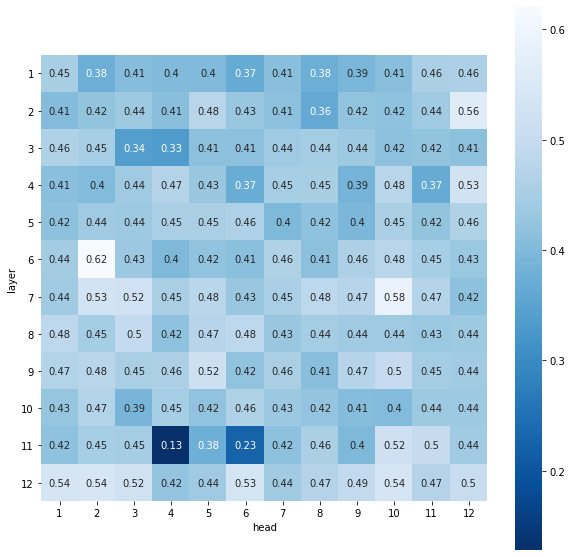

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(np.nanmean(results, axis=2), cmap='Blues_r', xticklabels=range(1, 12+1), yticklabels=range(1, 12+1), square=True, annot=True, ax=ax)
plt.yticks(rotation=0)
plt.xlabel('head')
plt.ylabel('layer')

### Paper: BertViz
- https://github.com/jessevig/bertviz

#### Layer view

In [ ]:
idx = 0

Text(0.01, 0.5, 'Layer')

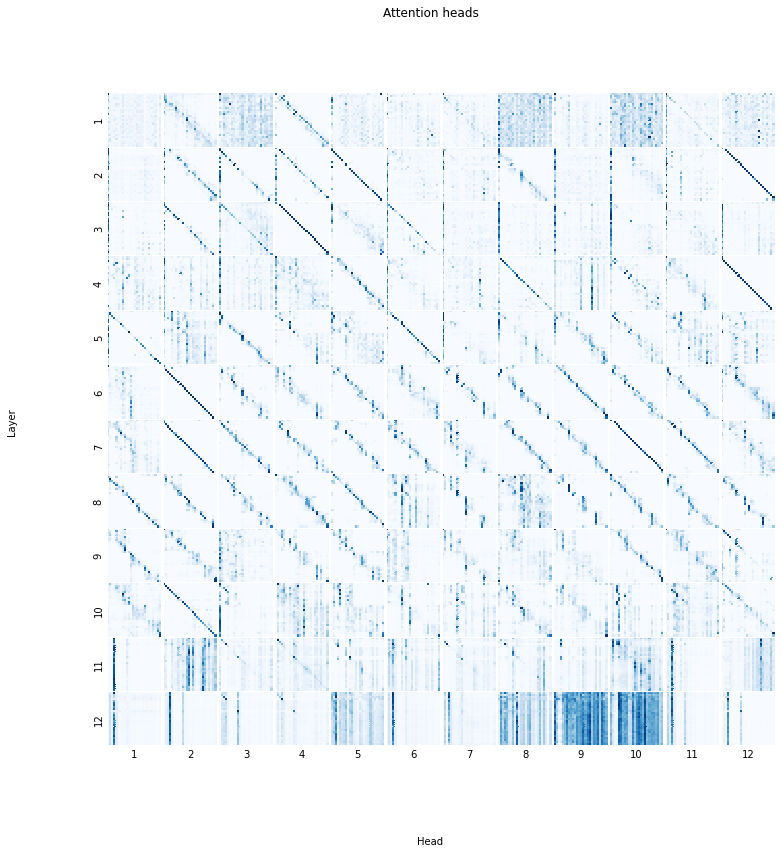

In [ ]:
size = 12
fig = plt.figure('foo', (size, size))
gs = gridspec.GridSpec(size, size)
gs.update(wspace=0., hspace=0.02)
for row in range(size):
  for col in range(size):
    ax = plt.subplot(gs[(row, col)])
    ax = sns.heatmap(finetuned_attention[idx][row, col], ax=ax, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False, square=True)
    if col == 0:
      ax.set_ylabel(row+1)
    if row == size-1:
      ax.set_xlabel(col+1)
fig.suptitle("Attention heads")
fig.text(0.5, 0.01, 'Head', ha='center')
fig.text(0.01, 0.5, 'Layer', va='center', rotation='vertical')
#fig.savefig('/content/gdrive/My Drive/Colab Notebooks/cs99/new-mt-dnn/checkpoints/bert-cased_lcp-single_2021-01-19T0309/finetuned_attention.png', dpi=fig.dpi)

#### Head view

In [35]:
sentence_1 = "fuck you."
tokens_1 = ['CLS']+tokenizer.tokenize(sentence_1)+['SEP']
inputs = torch.zeros((1, 512), dtype=torch.long).to(device)
input_ids = torch.tensor(tokenizer.encode(sentence_1))
inputs[:, :len(input_ids)] = input_ids
logits = model(inputs)[0]
attention_1 = torch.vstack(model(inputs)[-1]).detach().cpu()[:, :, :input_ids.size(0), :input_ids.size(0)]
pred = torch.sigmoid(logits)
print(pred)

tensor([[0.9544, 0.0531, 0.7755, 0.0066, 0.6124, 0.0260]], device='cuda:0',
       grad_fn=<SigmoidBackward>)


In [37]:
sentence_2 = "bless you."
tokens_2 = ['CLS']+tokenizer.tokenize(sentence_2)+['SEP']
inputs = torch.zeros((1, 512), dtype=torch.long).to(device)
input_ids = torch.tensor(tokenizer.encode(sentence_2))
inputs[:, :len(input_ids)] = input_ids
logits = model(inputs)[0]
attention_2 = torch.vstack(model(inputs)[-1]).detach().cpu()[:, :, :input_ids.size(0), :input_ids.size(0)]
pred = torch.sigmoid(logits)
print(pred)

tensor([[0.1809, 0.0045, 0.0608, 0.0038, 0.0259, 0.0094]], device='cuda:0',
       grad_fn=<SigmoidBackward>)


Text(0.5, 1.0, 'sentence 2')

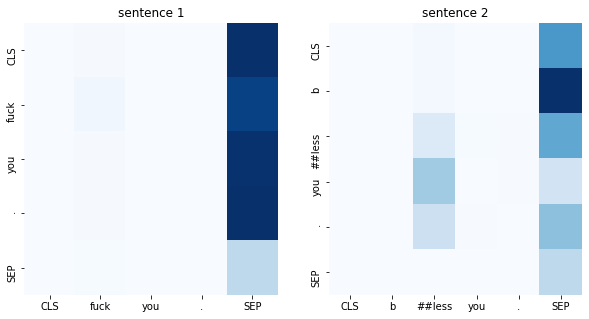

In [38]:
#idx = 43
layer, head = 10, 7
#tokens = tokens_lst[idx]
plt.rcParams['figure.figsize'] = [10, 5]
fig, axes = plt.subplots(1, 2)
sns.heatmap(attention_1[layer-1, head-1], ax=axes[0], cmap="Blues", xticklabels=tokens_1, yticklabels=tokens_1, cbar=False)
axes[0].set_title('sentence 1')
sns.heatmap(attention_2[layer-1, head-1], ax=axes[1], cmap="Blues", xticklabels=tokens_2, yticklabels=tokens_2, cbar=False)
axes[1].set_title('sentence 2')

In [46]:
data[data['toxic']==0].sample()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_cleaned,idx,bad_word_spans
128878,b13731c4c90c7d48,"Sorry but I'm a bit unsure how to go about this but I took the Image Dais6556.JPG and am the copyright holder, Thanks Hilda.",0,0,0,0,0,0,"Sorry but I'm a bit unsure how to go about this but I took the Image Dais6556.JPG and am the copyright holder, Thanks Hilda.",1118,[]


Text(0.5, 1.0, 'Fine-tuned')

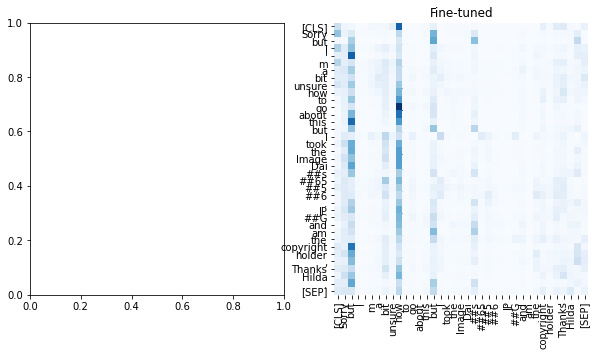

In [47]:
idx = 1118
layer, head = 10, 7
tokens = tokens_lst[idx]
plt.rcParams['figure.figsize'] = [10, 5]
fig, axes = plt.subplots(1, 2)
sns.heatmap(finetuned_attention[idx][layer-1, head-1], ax=axes[1], cmap="Blues", xticklabels=tokens, yticklabels=tokens, cbar=False)
axes[1].set_title('Fine-tuned')

In [ ]:
call_html()
f = tuple(finetuned_attention[idx][i].unsqueeze(0) for i in range(12))
head_view(f, tokens)

Output hidden; open in https://colab.research.google.com to view.

### Paper: Are Sixteen Heads Really Better than One?
- https://github.com/abidlabs/pytorch-transformers/blob/master/examples/run_bertology.py

#### Head importance & Attention Entropy
- Grab fine-tuned model.
- Backprop dev set.

In [ ]:
cd $directory

/content/gdrive/MyDrive/Colab Notebooks/cs89.21


In [ ]:
%cd /content/gdrive/MyDrive/Colab Notebooks/cs99/new-mt-dnn

/content/gdrive/MyDrive/Colab Notebooks/cs99/new-mt-dnn


In [ ]:
!python run_bertology.py --seed 2020 --checkpoint '/content/gdrive/MyDrive/Colab Notebooks/cs89.21/checkpoints/bert_model_cased_not_lowered/model_1.pt' --output_dir '/content/gdrive/MyDrive/Colab Notebooks/cs89.21/checkpoints/bert_model_cased_not_lowered/' --batch_size 8

2021-03-14 02:12:26.619804: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a mode

In [40]:
finetuned_importances = np.load('{}/checkpoints/bert_model_cased_not_lowered/head_importance_before_normalization.npy'.format(directory))

Text(69.0, 0.5, 'Layer')

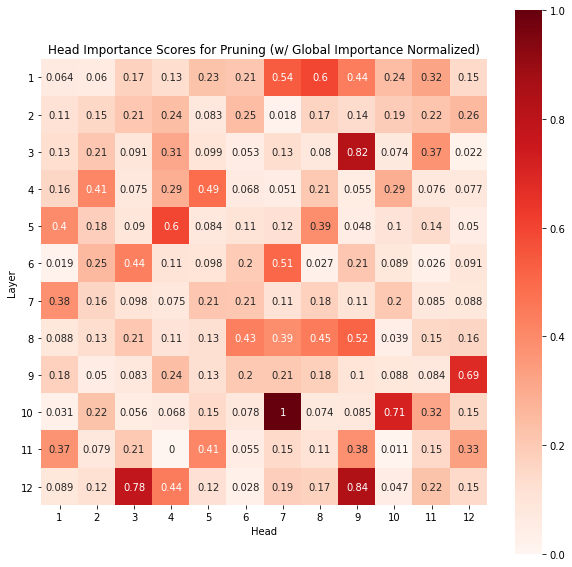

In [45]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(finetuned_importances, cmap='Reds', xticklabels=range(1, 12+1), yticklabels=range(1, 12+1), square=True, annot=True, ax=ax)
plt.yticks(rotation=0)
plt.title('Head Importance Scores for Pruning (w/ Global Importance Normalized)')
plt.xlabel('Head')
plt.ylabel('Layer')